In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as nfft

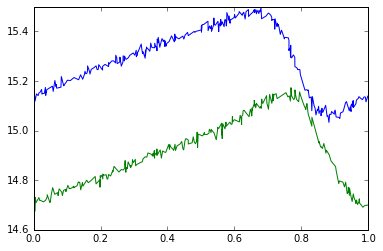

In [3]:
d16=np.genfromtxt('169975.dat_folded')
d51=np.genfromtxt('51886.dat_folded')
plt.plot(d16[:,0], d16[:,1])
plt.plot(d51[:,0], d51[:,1])

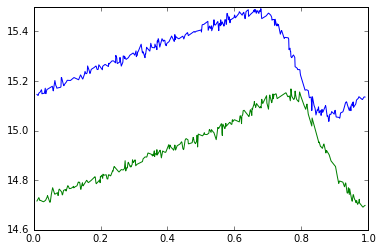

In [4]:
from scipy.interpolate import interp1d
x1 = np.linspace(0.01,0.99, 1024)
c51=interp1d(d51[:,0], d51[:,1])(x1)
c16=interp1d(d16[:,0], d16[:,1])(x1)
plt.plot(x1, c16)
plt.plot(x1, c51)

## Q1. Computing Cross-Correlation

We provide here a standardization function

In [11]:
def stand(x):
    return (x-np.mean(x))/np.std(x, ddof=0)

Write a function that takes two time seroes and uses the fourier method to calculate a cross-correlation function

In [16]:
def ccor(ts1, ts2):
    #your code here
    return nfft.fft(nfft.ifft(ts1)*np.conj(nfft.ifft(ts2)))

We plot the correlation function. Where does it maximize?

/Users/rodrickkuatedefo/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


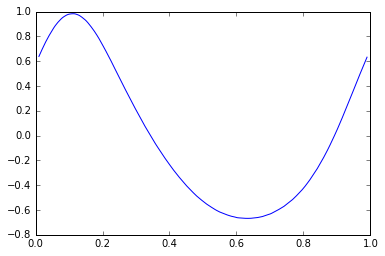

In [17]:
plt.plot(x1, ccor(stand(c51), stand(c16)))

The correlation function maximizes at about a shift of 0.1, as we would expect.

## Q2. Dimensionality reduction with SAX

The idea behind SAX is to reduce dinensionality by capturing pieces of the curve and getting an average. So you are replacing the function by a set of steps. The next part is to encode the steps using some technique, here we will use binary strings. The [iSAX paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwi2y4u9p__LAhUD9R4KHYslCuAQFggdMAA&url=http%3A%2F%2Fwww.cs.ucr.edu%2F~eamonn%2FiSAX.pdf&usg=AFQjCNEhDE8xHlXBVfSkLUBo4UsVRHOyTw&sig2=dgG-oNiR2MAYcqyUWzCs3Q), which you should skim, at the very least, is the source of this explanation below

![](https://dl.dropboxusercontent.com/u/75194/saxrepr.png)



Our interpolated curves have 1024 points. Bin them in chunks of 32, so we have $w=32$ chunks, and use a cardinality $a=4$ to get a SAX(T, 32, 4). Represent both light curves this way. For bonus points solve it for a general cardinality a (you'll have to get the gaussian deivision from the table above).

Remember you are doing this on standardized time series. You can assume that the series has been interpolated to a power of 2 length. Write a function to do this below:

In [76]:
import scipy
from scipy import optimize

def f(z):
    return 1/2*(1+scipy.special.erf(z/np.sqrt(2)))

def breakpointfinder(breakpoints,a):
    areas = np.ones((len(breakpoints)+1))
    areas[:-1] = f(breakpoints)
    areas[1:] = np.array([areas[j]-areas[j-1] for j in range(1,len(areas))])
    return np.sum((np.array(areas)-1./a)**2)
    
    
def representer4(series, w): # a will be 4
    #your code here
    a = 4
    res = scipy.optimize.minimize(breakpointfinder,(np.array(range(a-1))-np.mean(np.array(range(a-1))))/(a-1)*2,args=a)
    symbols = ['{0:b}'.format(i).zfill(int(np.log(a-1)/np.log(2))+1) for i in range(a-1,-1,-1)]
    breakpoints = res.x
    breakpoints = np.array([*breakpoints,np.inf])
    T = np.zeros((w))
    n = len(series)
    SAX = []
    for i in range(w):
        T[i] = w/n*sum([series[j] for j in range(int(n/w*(i-1)),int(n/w*i))])
        for j in range(a):
            if j == a-1:
                SAX.append(symbols[j])
                break
            if T[i]<breakpoints[0]:
                SAX.append(symbols[0])
                break
            if T[i]>breakpoints[j] and T[i]<breakpoints[j+1]:
                SAX.append(symbols[j+1])
                break
    return SAX
    

We apply the function

In [78]:
representer4(stand(c51), 32)

['11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '01',
 '01',
 '01',
 '01',
 '01',
 '00',
 '00',
 '00',
 '00',
 '00',
 '00',
 '00',
 '00',
 '00',
 '01',
 '10',
 '11',
 '11']

In [79]:
representer4(stand(c16), 32)

['11',
 '11',
 '11',
 '11',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '01',
 '01',
 '01',
 '01',
 '01',
 '00',
 '00',
 '00',
 '00',
 '00',
 '00',
 '00',
 '00',
 '00',
 '00',
 '01',
 '10',
 '11',
 '11',
 '11',
 '11',
 '11']

## Q3. VPTree (to read, not to submit)

Read the VPTree implementation is modified from https://github.com/huyng/algorithms/tree/master/vptree. Also see http://stevehanov.ca/blog/index.php?id=130 for a good explanation of the concepts (and C++ code if you are so inclined). You will use the VPtree to store some distances next week in an index so it is imperative that you read atleast one implementation.

